In [1]:
import os 
import copy 
import numpy as np
np.set_printoptions(suppress=True, precision=4)

from scipy.spatial.transform import Rotation as R

import open3d as o3d

import symforce 
# symforce.set_log_level("warning")
symforce.set_log_level("ERROR")
print(f"symforce uses {symforce.get_symbolic_api()} as backend")

from symforce.notebook_util import display
import symforce.symbolic as sf
from symforce.values import Values
from symforce import ops
from symforce.ops import StorageOps, GroupOps, LieGroupOps

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
symforce uses symengine as backend


=========INFO==========
The shape and equation of error_model:


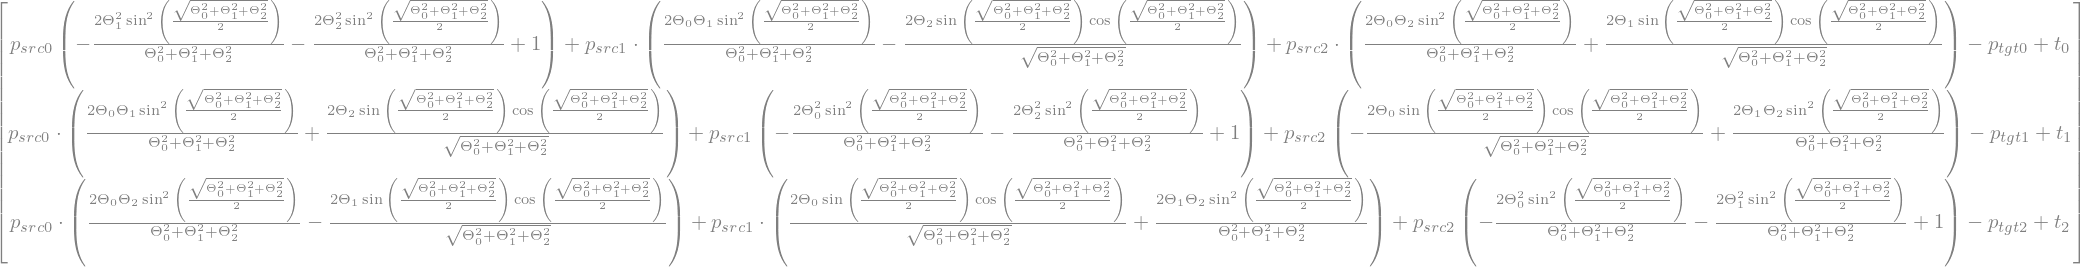


=========INFO==========
The shape and equation of Je_rot:


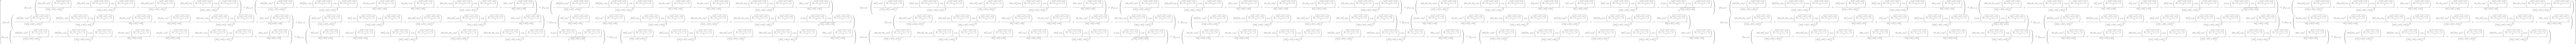


=========INFO==========
The shape and equation of Je_trans:


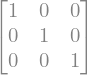

In [2]:

# Model parameters (as symbolic)
transvec = sf.V3.symbolic("t")
rotvec   = sf.V3.symbolic("Theta") # i.e., angle-axis parametrization
rotmat   = LieGroupOps.from_tangent(sf.Rot3, rotvec) # for debug, display(rotmat.to_rotation_matrix())

# Redisual (loss function)
#  note: the rotation 'matrix' is used to formulate the below constraint, 
#        but it was parametrized as a 3-dim vector 'rotvec'!
p_src        = sf.V3.symbolic("p_src")     # p means a single 3D point 
p_tgt        = sf.V3.symbolic("p_tgt") 
p_tgt_est    = (rotmat * p_src) + transvec # The constraint: R*p + t == p'
error_model  = p_tgt_est - p_tgt           # this is our loss function to minimize 
# error_model = p_tgt - p_tgt_est          # it would have same result as the above (test yourself!)

# residual jacobian
#  this is the powerful moment of symforce. It automatically generate the Jacobian equations explicitly. 
Je_trans_model = error_model.jacobian(transvec)
Je_rot_model = error_model.jacobian(rotvec)

# residual debug 
is_vis_jacobians = True

def disp_info(elm, name=''):
    print("=========INFO==========")
    print(f"The shape and equation of {name}:")
    display(elm.shape)
    display(elm)
    print("=======================\n")

if is_vis_jacobians:
    disp_info(error_model, 'error_model')
    disp_info(Je_rot_model, 'Je_rot')
    disp_info(Je_trans_model, 'Je_trans')


In [4]:

# The nonlinear icp alg. 
def evaluate_error_and_jacobian(src_pt: np.ndarray, tag_pt: np.ndarray, transformation):
    # note: transformation is 6dim vector on the tangent space (i.e., [rotvec, trans])

    def inject_values(model):
        model_evaluated = \
            model.subs(rotvec, sf.V3(transformation[:3])) \
                 .subs(transvec, sf.V3(transformation[3:])) \
                 .subs(p_src, sf.V3(src_pt)) \
                 .subs(p_tgt, sf.V3(tag_pt)) 
        return model_evaluated
        
    error = inject_values(error_model) 
    Je_rot = inject_values(Je_rot_model)
    Je_trans = inject_values(Je_trans_model)

    is_numpying = True
    if is_numpying:
        error = error.to_numpy()
        Je_rot = Je_rot.to_numpy()
        Je_trans = Je_trans.to_numpy()

    return error, Je_rot, Je_trans
    

def icp(src, tgt, tf_init, max_iter=1, verbose=False):

    tf = tf_init # 6 dim
    num_pts = src.shape[0]

    for _iter in range(max_iter):
        # reset for each iter
        H = np.zeros((6, 6))
        b = np.zeros((6, 1))

        # gathering measurements
        for pt_idx in range(num_pts):
            # Here, we directly use the true-known pair (because this is a tutorial for educational purpose :)
            #  In practice, (src_pt, tgt_pt) should be a correspondence (e.g., found by FPFH local featuer, see https://pcl.readthedocs.io/projects/tutorials/en/latest/fpfh_estimation.html)
            src_pt = src[pt_idx, :]
            tgt_pt = tgt[pt_idx, :]
            
            # ps.
            #   To understand the details of this nonlinear iterative update steps, see http://www.diag.uniroma1.it//~labrococo/tutorial_icra_2016/icra16_slam_tutorial_grisetti.pdf 
            #    however, in the above slide's example, the jacobian was generated by hand as well as Euler angle space was used, not angle-axis.
            e, Je_rot, Je_trans \
                = evaluate_error_and_jacobian(src_pt, tgt_pt, tf)
            
            J = np.hstack((Je_rot, Je_trans)) # thus, 3x6
            
            H = H + J.T @ J # H: 6x3 * 3x6 => thus H is 6x6
            b = b + J.T @ e # b: 6x3 * 3x1 => thus b is 6x1

            if verbose:
                print("\n=================")
                print(f"{pt_idx} error is\n{e.T}")
                print(f"{pt_idx} Je_rot is\n{Je_rot}")
                print(f"{pt_idx} Je_trans is\n{Je_trans}")
                print(f"{pt_idx} J is\n{J}")
                print(f"{pt_idx} H is\n{H}")
                print(f"{pt_idx} b is\n{b}")

            # if "true" correspondence is given (this is an tutorial for education purpose), 
            #  using a few points okay ..
            if pt_idx > 10:
                break

        dtf = -np.linalg.solve(H, b).squeeze() # note the step direction is minus
        tf = tf + dtf # updated within the tangent space

        if verbose:
            print("\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
            print(f"iter {_iter} dtf is\n{dtf}")
            print(f"iter {_iter} tf is\n{tf}")
            print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

    return tf


In [5]:
# Data generatation  
#  source 
pcd0 = o3d.io.read_point_cloud('data/251371071.pcd')

#  generate target 
rot_yaw_5deg = np.array([0.9961947, -0.0871557,  0.0000000,
                         0.0871557,  0.9961947,  0.0000000,
                         0.0000000,  0.0000000,  1.0000000]).reshape(3, 3)
trans_move = np.expand_dims(np.array([-0.2335, 0.5, 0]), axis=-1)
diff_SE3 = np.vstack((np.hstack((rot_yaw_5deg, trans_move)), [0,0,0,1]))

pcd1 = copy.deepcopy(pcd0)
pcd1 = pcd1.transform(diff_SE3)

src_pc = np.array(pcd0.points)
tgt_pc = np.array(pcd1.points)

is_viz = 0
if is_viz:
    pcd0.paint_uniform_color([1, 0, 0])
    pcd1.paint_uniform_color([0, 1, 0])
    o3d.visualization.draw_geometries([pcd0, pcd1])
    

In [6]:
# Main 
eps = 0.0001
init_guess = np.zeros(6) + eps # because zero initial should be avoided (see the symbolic equation of Je_rot!)

# in this tutorial, we must use max_iter=1
#  for multiple iterations' structure, per-iter small registration and recalculation of correspondences are must be followed.
#  see 'nonlinear_icp_sim3' in this repo. 
tf_tangent = icp(src_pc, tgt_pc, init_guess, max_iter=1, verbose=False) # if "true" correspondence is given (this is an tutorial for education purpose), using a few iteration okay ..

# Verify the result 
print("\n==========   true   ==========")
print(f"relative rotation:\n{rot_yaw_5deg}")
print(f"relative translation:\n{trans_move.T}")

tf_trans, tf_rotmat = tf_tangent[3:], R.from_rotvec(tf_tangent[:3])
print("\n==========estimation==========")
print(f"relative rotation:\n{tf_rotmat.as_matrix()}")
print(f"relative translation:\n{tf_trans}")


==========   true   ==========
relative rotation:
[[ 0.9962 -0.0872  0.    ]
 [ 0.0872  0.9962  0.    ]
 [ 0.      0.      1.    ]]
relative translation:
[[-0.2335  0.5     0.    ]]

==========estimation==========
relative rotation:
[[ 0.9962 -0.087   0.    ]
 [ 0.087   0.9962 -0.0001]
 [ 0.      0.0001  1.    ]]
relative translation:
[-0.2335  0.4901 -0.0004]
